In [27]:
%pip install torch
%pip install torchvision
%pip install numpy
%pip install torchsummary
%pip install tqdm
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [29]:
from torchvision import datasets, transforms

# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [30]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)

test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [31]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        )
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        )
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [33]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)
summary(model, input_size=(1, 28, 28)) 

device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
model = Net().to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]             864
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1, 12,

In [34]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [35]:
model =  Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.21945057809352875 Batch_id=937 Accuracy=86.80: 100%|██████████| 938/938 [00:09<00:00, 94.97it/s]  



Test set: Average loss: 0.1080, Accuracy: 9683/10000 (96.83%)

EPOCH: 1


Loss=0.04322529584169388 Batch_id=937 Accuracy=97.00: 100%|██████████| 938/938 [00:08<00:00, 107.59it/s] 



Test set: Average loss: 0.0693, Accuracy: 9794/10000 (97.94%)

EPOCH: 2


Loss=0.09188033640384674 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:08<00:00, 107.37it/s] 



Test set: Average loss: 0.0649, Accuracy: 9786/10000 (97.86%)

EPOCH: 3


Loss=0.36579394340515137 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:08<00:00, 108.05it/s] 



Test set: Average loss: 0.0541, Accuracy: 9816/10000 (98.16%)

EPOCH: 4


Loss=0.11697840690612793 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:08<00:00, 107.81it/s]  



Test set: Average loss: 0.0404, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


Loss=0.03292398154735565 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [00:08<00:00, 107.87it/s]  



Test set: Average loss: 0.0460, Accuracy: 9844/10000 (98.44%)

EPOCH: 6


Loss=0.05370471626520157 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:08<00:00, 109.38it/s]  



Test set: Average loss: 0.0351, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.029116207733750343 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [00:08<00:00, 109.14it/s] 



Test set: Average loss: 0.0354, Accuracy: 9885/10000 (98.85%)

EPOCH: 8


Loss=0.016293669119477272 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:08<00:00, 109.82it/s] 



Test set: Average loss: 0.0470, Accuracy: 9853/10000 (98.53%)

EPOCH: 9


Loss=0.06287017464637756 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:08<00:00, 109.29it/s]  



Test set: Average loss: 0.0382, Accuracy: 9876/10000 (98.76%)

EPOCH: 10


Loss=0.008097639307379723 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:08<00:00, 107.44it/s] 



Test set: Average loss: 0.0365, Accuracy: 9879/10000 (98.79%)

EPOCH: 11


Loss=0.23407042026519775 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:08<00:00, 108.23it/s]  



Test set: Average loss: 0.0332, Accuracy: 9885/10000 (98.85%)

EPOCH: 12


Loss=0.027397269383072853 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:08<00:00, 108.87it/s] 



Test set: Average loss: 0.0293, Accuracy: 9897/10000 (98.97%)

EPOCH: 13


Loss=0.23695752024650574 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:08<00:00, 108.76it/s]  



Test set: Average loss: 0.0471, Accuracy: 9847/10000 (98.47%)

EPOCH: 14


Loss=0.0036216380540281534 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:08<00:00, 106.72it/s]



Test set: Average loss: 0.0265, Accuracy: 9921/10000 (99.21%)



Text(0.5, 1.0, 'Test Accuracy')

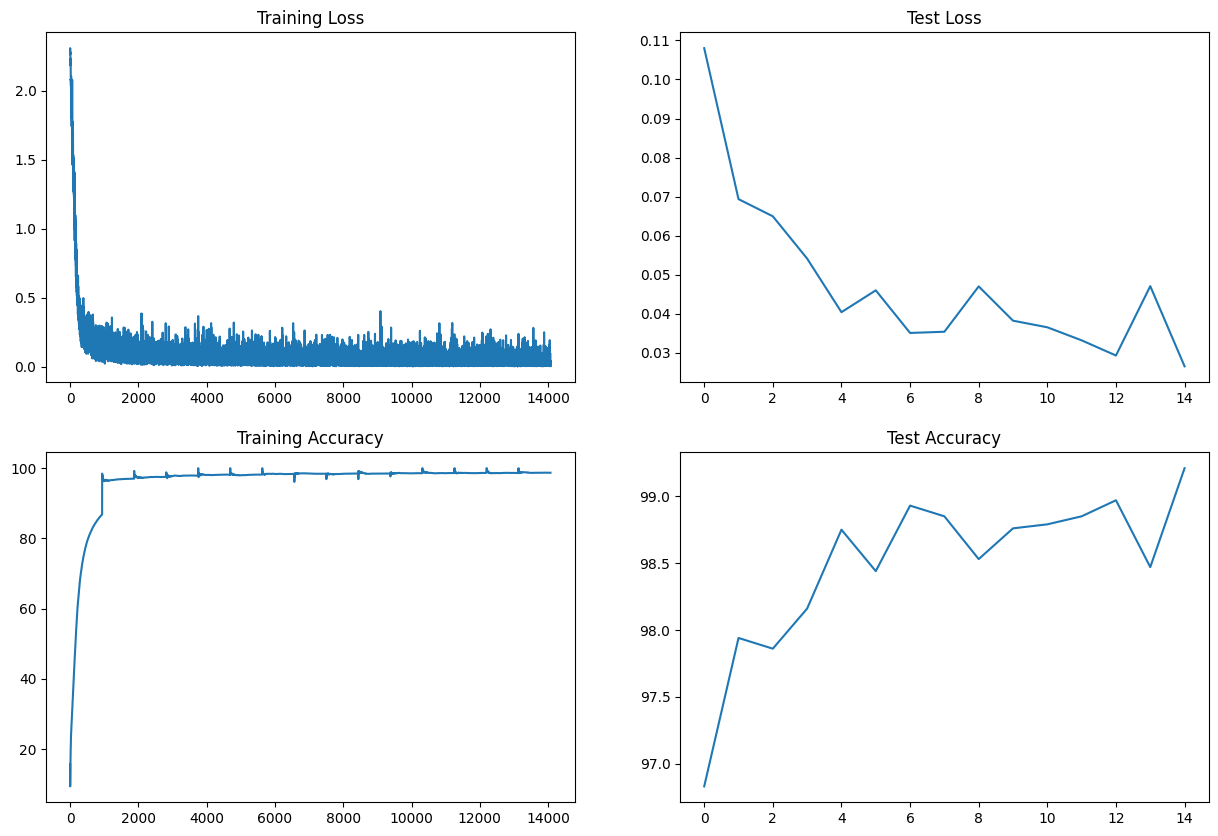

In [36]:
t = [t_items.item() for t_items in train_losses]


import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target:**
  
*   Reduce parameters to 5k count
*   Make sure, defined model get trained
*   Limit the 15 epoch


**Results:**


*   Parameters: 5,048
*   Best Training Accuracy: 98.71
*   Best Test Accuracy: 99.21


**Analysis:**


*   Light weight Model
*   Added Batch Normalization, MaxPool2d and dropout = 0.1
*   Model is getting trained in very efficent way and in very fast